# Waveform Fitter that partially recycle DROP modules 


<span style="color:blue">**The analysis is in progress! But hopefully this notebook serves as an example, when analysis on raw waveform is needed. Contact Xin for any questions.**</span>.

Disclaim: the class `WaveformFitter` below is not a derived class from any DROP module. DROP classes are imported for usage, but there is no inherience structure here. I took the easist path when it comes to recycle old code --- copy & paste. Although I wish I have done better job coding wise, it should work (see the cell after class definition). 

Before Runing this notebook, activiate the same virtual enviroment which contains the same installed package as `drop`:
- Enter python environment:
    ```bash
    source env/bin/activate
    pip install iminuit
    ```
The `iminuit` installation is a one time thing. `iminuit` is the Minuit2 algorthim packaged in python. I used it to do fitting. 

- Setup DROP environmental variables
    ```bash
    source setup.sh
    ```
- Make sure you have the access to raw data. One can stream via Milind's workstation, or download them from cernbox. Xin has a set of raw data that containing the tagged crossing muons only. See [descrption here](https://docs.google.com/presentation/d/1nK676QLG2FaYvYUKNHCqxgngAhFbhNJfFRRpZJCQ7CQ/edit#slide=id.g1c84e8b3c41_1_18) . The set is not very big. Analysis on the slim data will be a lot faster.

# 1. Get the data

In [9]:
"""
Load packages
"""
import os
import sys
import numpy as np
import re
import glob
from datetime import datetime
from numpy import array, isscalar, uint16, uint32
import pandas as pd
from iminuit import Minuit
import uproot
print("uproot version:", uproot.__version__)

"""
plotting preference
"""
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["font.size"] = 14

"""
Load drop modules

Note: 
    run setup.sh to get environemtal variables: SOURCE_DIR, YAML_DIR, etc
"""
SRC_DIR = os.environ['SOURCE_DIR']
YAML_DIR = os.environ['YAML_DIR']
sys.path.append(SRC_DIR)
from utilities import generate_colormap
from run_drop import RunDROP
from waveform import Waveform
from yaml_reader import YamlReader
from pulse_finder import PulseFinder
from yaml_reader import SAMPLE_TO_NS


# def extract_datetime_from_str(s):
#     """
#     Extract datatime from a str. The datetime must follow the fixed format:
#     YYmmddTHHMM
#     """
#     match = re.search(r'\d{6}T\d{4}', s)
#     try:
#         dt = datetime.strptime(match.group(), '%y%m%dT%H%M')
#         return dt
#     except ValueError:
#         print('Fail finding the datetime string from path: %s' % s)
    
class WaveformFitter():
    def __init__(self, raw_data_path, yaml_path='../yaml/config.yaml'):
        """
        Constructor. Make a superclass using DROP modules.
        
        Args:
            raw_data_path (str): path to the raw root file
            yaml_path (str): path to the configuration yaml file (default:
                yaml/config.yaml)
        """
        self.cfg = YamlReader(yaml_path) # load yaml config
        self.if_path = raw_data_path
        self.load_run_info()
        self.load_pmt_info()
        
        # get daq tree via uproot
        f = uproot.open(raw_data_path)
        self.n_entries = f['daq'].num_entries
        self.wfm = Waveform(self.cfg)
        self.wfm.ch_names=self.ch_names
        self.wfm.ch_id = self.ch_id
        self.wfm.n_boards = self.n_boards
        self.wfm.spe_mean = self.spe_mean
        self.daq = f['daq'].arrays()
        self.entry_id = 0
        
    def load_run_info(self):
        """
        I copied this function from run_drop.py
        """
        f = uproot.open(self.if_path)
        dt = extract_datetime_from_str(self.if_path)
        a = f['run_info'].arrays(['n_boards', 'active_ch_id', 'n_event_proc'], library='np')
        self.n_boards = uint16(a['n_boards'][0])
        self.n_event_proc = uint32(a['n_event_proc'][0])
        tmp = a['active_ch_id'][0]
        if isscalar(tmp): # if only 1 active channels, tmp is a scalar and sort will fail
            tmp = [tmp]
        self.ch_id = sorted(uint16(tmp))
        self.ch_names = ["adc_b%d_ch%d" % (i // 100, i % 100) for i in self.ch_id]
        self.ch_name_to_id_dict = dict(zip(self.ch_names, self.ch_id))
    
    def load_pmt_info(self):
        """
        I copied this function from run_drop.py
        """
        self.spe_mean = {}
        fpath = self.cfg.spe_fit_results_file
        if self.cfg.interpolate_spe:
            dt = extract_datetime_from_str(self.if_path)
            fdir = os.path.dirname(fpath)
            led_paths=glob.glob("%s/*.csv" % fdir)
            p0, p1 = None, None
            t0, t1 = 999999, 999999 # arbitary large
            for p in led_paths:
                delta = dt-extract_datetime_from_str(p)
                delta_min = delta.total_seconds()/60
                if delta_min>=0:
                    if abs(delta_min)<t0:
                        t0 = abs(delta_min)
                        p0 = p
                else:
                    if abs(delta_min)<t1:
                        t1 = abs(delta_min)
                        p1 = p
            if p1 is None:
                self._set_spe_result(p0)
                print('Info: using calibration results from', p0)
            else:
                self._set_spe_result(p0)
                df0 = pd.read_csv(p0)
                df1 = pd.read_csv(p1)
                df0.set_index('ch_name', inplace=True)
                df1.set_index('ch_name', inplace=True)
                ch_names = df0.index
                for ch in ch_names:
                    x0 = df0['spe_mean'][ch]
                    x1 = df1['spe_mean'][ch]
                    self.spe_mean[ch] = x0 + (x1-x0)/(t0+t1) * t0
                    # self.spe_fit_results['spe_mean'][ch] = self.spe_mean[ch]
                    self.spe_fit_results.loc[ch, 'spe_mean'] = self.spe_mean[ch]
                print('Info: Intepolate from calibration results', p0, 'and', p1)
        else:
            self._set_spe_result(fpath)
            print('Info: using calibration results from', fpath)

    def _set_spe_result(self, fpath):
        """
        I copied this function from run_drop.py
        """
        try:
            df = pd.read_csv(fpath)
            df.set_index('ch_name', inplace=True)
            self.spe_fit_results  = df # to be saved in root
            ch_names = df.index
            for ch in ch_names:
                self.spe_mean[ch] = float(df['spe_mean'][ch])
        except:
            sys.exit("your spe_fit_results_file cannot be loaded properly!")
        
    def process_one(self, i):    
        """
        Different name. Similar to a function in run_drop.py. Given an entry index, process that entry.
        """
        self.event_id = self.daq[i].event_id
        self.event_ttt = self.daq[i].event_ttt
        self.wfm.reset()
        self.wfm.set_raw_data(self.daq[i])
        self.wfm.find_saturation()
        self.wfm.subtract_flat_baseline()
            #wfm.find_ma_baseline()
        self.wfm.do_spe_normalization()
        self.wfm.define_trigger_position()
        self.wfm.correct_daisy_chain_trg_delay()
        self.wfm.sum_channels()
        self.wfm.define_time_axis()
        self.wfm.integrate_waveform()
        self.wfm.calc_roi_info()
        self.wfm.calc_aux_ch_info()

    def process_next(self):
        """
        Put process one in a loop
        """
        if self.entry_id<self.n_entries:
            i = self.entry_id
            self.process_one(i)
            self.entry_id+=1
            return True
        else:
            return False
            
    def get_wfm_data(self, t_min=370, t_max=470, ch_name='sum_bot'):
        """
        Arg:
            t_min: float
            t_max: float
            ch_name: channel names identical to how it's defined in DROP. 
        Options: sum_bot, sum_side, sum_row1,..., sum_row4, ..., sum_col1,..., sum_col4. 
        Individual channels are accessible too. For example, adc_b1_ch3 is board 1 channel 3.
        """
        t = self.wfm.time_axis_ns
        mask = (t>=t_min) & (t<t_max)
        x_data=t[mask]
        y_data=wf.wfm.amp_pe[ch_name][mask]
        return x_data, y_data

uproot version: 4.1.9


Info: Intepolate from calibration results /Users/xxiang/MyGitHub/Gmail/drop/analysis/db/spe/b/bnl1t_spe_fit_results_220819T1401.csv and /Users/xxiang/MyGitHub/Gmail/drop/analysis/db/spe/b/bnl1t_spe_fit_results_220913T0000.csv
run_id: 220901T1040 event_id 35


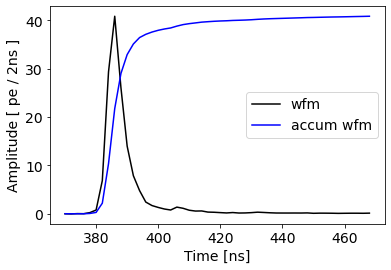

In [15]:
"""
Example: usage of WaveformFitter class (feel free to change the class name since 
there is no fitting method currently implemented).
"""

# define path to your raw root file
DATA_DIR='/Users/xxiang/MyGitHub/Gmail/drop/data/crx_mu'
data_path=DATA_DIR+'/phase0_muon_water_220901T1040_small.root'

# init WaveformFitter obj. By default, ../yaml/config.yaml is the second argument.
wf = WaveformFitter(data_path)

# process the first entry
wf.process_one(0)
event_id=wf.event_id
run_id = re.search(r'\d{6}T\d{4}', data_path).group() # this is a string
print('run_id:', run_id, "event_id", event_id)

# get the data between t_min and t_max. 
x_data, y_data = wf.get_wfm_data(t_min=370, t_max=470, ch_name='sum_bot')
plt.plot(x_data, y_data, color='k', label='wfm')
y_int=np.cumsum(y_data)
y_int=y_int/y_int[-1]*np.max(y_data)
plt.plot(x_data, y_int, color='blue', label='accum wfm')
plt.legend()
plt.xlabel('Time [ns]')
plt.ylabel('Amplitude [ pe / 2ns ]')
plt.show()

# Do one fit

In [16]:
from iminuit.cost import LeastSquares

def double_expo(t, A1=1, t0=0, tR=1, tF1=3):
    dT = tF1-tR
    if dT == 0:
        return None
    else:
        y = (np.exp(-(t-t0)/tF1)-np.exp(-(t-t0)/tR))/dT
    return A1*y*np.heaviside(t-t0, 0.5)

def triple_expo(t, A1=1, A2=1, t0=0, tR=1, tF1=3, tF2=7):
    dT1 = tF1-tR
    dT2 = tF2-tR
    if dT1==0 or dT2==0:
        return None
    else:
        y = A1*(np.exp(-(t-t0)/tF1)-np.exp(-(t-t0)/tR))/dT1
        y += A2*(np.exp(-(t-t0)/tF2)-np.exp(-(t-t0)/tR))/dT2
    return y*np.heaviside(t-t0, 0.5)


y_pos = np.where(y_data<0, 0, y_data)
y_err = np.sqrt(np.square(y_err) + y_pos)
myfunc=double_expo

lsq = LeastSquares(x_data, y_data, y_err, myfunc)
if myfunc==double_expo:
    m = Minuit(lsq, A1=200, t0=375, tR=2, tF1=5)  # starting values for α and β
else:
    m = Minuit(lsq, A1=300, A2=200, t0=375, tR=2, tF1=4, tF2=9)  # starting values for α and β
m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.678 (chi2/ndof = 0.1)    │              Nfcn = 167              │
│ EDM = 7.5e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1   │    270    │    60     │            │            │         │         │       │
│ 1 │ t0   │  381.80   │   0.25    │            │            │         │         │       │
│ 2 │ tR   │    2.1    │    2.8    │            │            │         │         │       │
│ 3 │ tF1  │    3.6    │    3.2    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────┐
│     │       A1       t0       tR      tF1 │
├─────┼─────────────────────────────────────┤
│  A1 │ 3.37e+03     2.11    -11.1     8.26 │
│  t0 │     2.11   0.0607   -0.271    0.208 │
│  tR │    -11.1   -0.271     7.61    -8.37 │
│ tF1 │     8.26    0.208    -8.37     10.3 │
└─────┴─────────────────────────────────────┘

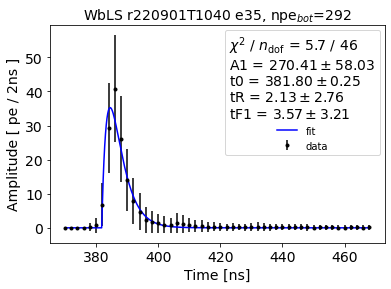

In [17]:
def plot_fit(func, save_fig=True, title_prefix='Water'):

    t=np.linspace(x_data[0], x_data[-1], 400)
    y=func(t, *m.values)
    plt.errorbar(x_data, y_data, y_err, linestyle='None', marker='.', color='k', label='data')
    plt.plot(t, y, color='blue', label='fit')
    npe=np.trapz(y_data, x_data)
    plt.title(r"%s r%s e%d, npe$_{bot}$=%d" % (title_prefix, run_id, event_id, npe), fontsize=14)
    fit_info = [
        f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x_data) - m.nfit}",
    ]
    for p, v, e in zip(m.parameters, m.values, m.errors):
        fit_info.append(f"{p} = ${v:.2f} \\pm {e:.2f}$")
    plt.legend(title="\n".join(fit_info), fontsize=10);
    plt.xlabel('Time [ns]')
    plt.ylabel('Amplitude [ pe / 2ns ]')
    if save_fig:
        if func==double_expo:
            filename_prefix='double_expo'
        elif func==triple_expo:
            filename_prefix='triple_expo'
        else:
            print('ERROR: func not recognized!')
            return None
        fname="%s_r%s_e%d.png" % (filename_prefix, run_id, event_id)
        plt.savefig('/Users/xxiang/MyGitHub/Gmail/drop/analysis/fig_dump/wfm_fit/'+fname)

plt.figure()
plot_fit(myfunc, title_prefix='WbLS', save_fig=True)
plt.show()

# do many fit

In [ ]:
file_list_water=[
    "phase0_muon_water_220901T1040_small.root",
#     "phase0_muon_water_220901T2011_small.root",
#     "phase0_muon_water_220907T1540_small.root",
#     "phase0_muon_water_220907T1633_small.root",
#     "phase0_muon_water_220907T2200_small.root",
#     "phase0_muon_water_220908T1000_small.root",
#     "phase0_muon_water_220908T1405_small.root",
#     "phase0_muon_water_220908T1947_small.root",
#     "phase0_muon_water_220909T1007_small.root",
#     "phase0_muon_water_220909T1502_small.root",
#     "phase0_muon_water_220909T2202_small.root",
#     "phase0_muon_water_220910T0013_small.root",
#     "phase0_muon_water_220910T0902_small.root",
#     "phase0_muon_water_220911T0050_small.root",
#     "phase0_muon_water_220911T0922_small.root",
#     "phase0_muon_water_220911T1516_small.root",
#     "phase0_muon_water_220911T2200_small.root",
#     "phase0_muon_water_220912T0654_small.root",
#     "phase0_muon_water_220912T1439_small.root",
#     "phase0_muon_water_220912T1735_small.root",
#     "phase0_muon_water_220913T0036_small.root",
#     "phase0_muon_water_220913T0831_small.root",
#     "phase0_muon_water_220913T1107_small.root",
#     "phase0_muon_water_220914T0019_small.root",
#     "phase0_muon_water_220914T0939_small.root",
#     "phase0_muon_water_220914T1802_small.root",
#     "phase0_muon_water_220915T0002_small.root",
#     "phase0_muon_water_220919T1743_small.root",
#     "phase0_muon_water_220920T0054_small.root",
#     "phase0_muon_water_220920T1046_small.root",
#     "phase0_muon_water_220920T1725_small.root"
]


file_list_wbls=[
    "phase1_muon_wbls_1pct_221025T0101_small.root",
#     "phase1_muon_wbls_1pct_221025T0930_small.root",
#     "phase1_muon_wbls_1pct_221025T1640_small.root",
#     "phase1_muon_wbls_1pct_221026T0013_small.root",
#     "phase1_muon_wbls_1pct_221026T1018_small.root",
#     "phase1_muon_wbls_1pct_221026T1756_small.root",
#     "phase1_muon_wbls_1pct_221027T0049_small.root",
#     "phase1_muon_wbls_1pct_221027T1027_small.root",
#     "phase1_muon_wbls_1pct_221027T1742_small.root",
#     "phase1_muon_wbls_1pct_221027T1859_small.root",
#     "phase1_muon_wbls_1pct_221028T1029_small.root",
#     "phase1_muon_wbls_1pct_221028T1717_small.root",
#     "phase1_muon_wbls_1pct_221029T0234_small.root",
#     "phase1_muon_wbls_1pct_221029T0751_small.root",
#     "phase1_muon_wbls_1pct_221029T1603_small.root",
#     "phase1_muon_wbls_1pct_221029T2320_small.root",
#     "phase1_muon_wbls_1pct_221030T0740_small.root",
#     "phase1_muon_wbls_1pct_221030T1840_small.root",
#     "phase1_muon_wbls_1pct_221031T0659_small.root",
#     "phase1_muon_wbls_1pct_221031T1657_small.root",
#     "phase1_muon_wbls_1pct_221031T2257_small.root",
#     "phase1_muon_wbls_1pct_221101T0927_small.root",
#     "phase1_muon_wbls_1pct_221101T1718_small.root",
#     "phase1_muon_wbls_1pct_221102T0036_small.root",
#     "phase1_muon_wbls_1pct_221102T0904_small.root",
#     "phase1_muon_wbls_1pct_221102T1739_small.root",
#     "phase1_muon_wbls_1pct_221102T2341_small.root",
#     "phase1_muon_wbls_1pct_221103T0932_small.root",
#     "phase1_muon_wbls_1pct_221103T1740_small.root",
#     "phase1_muon_wbls_1pct_221103T2324_small.root",
#     "phase1_muon_wbls_1pct_221105T0744_small.root",
#     "phase1_muon_wbls_1pct_221105T1052_small.root",
]

for fname in file_list_wbls:
    data_path=DATA_DIR+'/' + fname
    wf = WaveformFitter(data_path)
    while (wf.process_next()):
        event_id=wf.event_id
        run_id = extract_datetime_from_str(data_path).strftime('%y%m%dT%H%M')
        x_data, y_data = wf.get_wfm_data(t_min=370, t_max=470)
        y_pos = np.where(y_data<0, 0, y_data)
        y_err = np.sqrt(np.square(y_err) + y_pos)
        lsq = LeastSquares(x_data, y_data, y_err, myfunc)

        if myfunc==double_expo:
            m = Minuit(lsq, A1=300, t0=375, tR=2, tF1=5)
        else:
            m = Minuit(lsq, A1=300, A2=100, t0=375, tR=2, tF1=4, tF2=9)  
        m.print_level=0
        m.migrad()  # finds minimum of least_squares function
        m.hesse()   # accurately computes uncertainties
        
        plt.figure()
        plot_fit(triple_expo, title_prefix='WbLS', save_fig=True)

Info: Intepolate from calibration results /Users/xxiang/MyGitHub/Gmail/drop/analysis/db/spe/b/bnl1t_spe_fit_results_221024T1936.csv and /Users/xxiang/MyGitHub/Gmail/drop/analysis/db/spe/b/bnl1t_spe_fit_results_221025T1631.csv


/var/folders/j2/xx2nfy1d7kl54yfk4m9z36080000gn/T/ipykernel_93403/2704110326.py:8: RuntimeWarning: overflow encountered in exp
  y = (np.exp(-(t-t0)/tF1)-np.exp(-(t-t0)/tR))/dT
/var/folders/j2/xx2nfy1d7kl54yfk4m9z36080000gn/T/ipykernel_93403/2704110326.py:9: RuntimeWarning: invalid value encountered in multiply
  return A1*y*np.heaviside(t-t0, 0.5)
/var/folders/j2/xx2nfy1d7kl54yfk4m9z36080000gn/T/ipykernel_93403/2704110326.py:8: RuntimeWarning: overflow encountered in exp
  y = (np.exp(-(t-t0)/tF1)-np.exp(-(t-t0)/tR))/dT
/var/folders/j2/xx2nfy1d7kl54yfk4m9z36080000gn/T/ipykernel_93403/2704110326.py:8: RuntimeWarning: overflow encountered in exp
  y = (np.exp(-(t-t0)/tF1)-np.exp(-(t-t0)/tR))/dT
/var/folders/j2/xx2nfy1d7kl54yfk4m9z36080000gn/T/ipykernel_93403/2704110326.py:9: RuntimeWarning: invalid value encountered in multiply
  return A1*y*np.heaviside(t-t0, 0.5)
/var/folders/j2/xx2nfy1d7kl54yfk4m9z36080000gn/T/ipykernel_93403/2704110326.py:8: RuntimeWarning: overflow encountered in ex